In [52]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pickle
import numpy as np
import os.path


In [53]:
def plotdea(file, loss: bool = True, title = ""):
    if "pkl" not in file:
        file += ".pkl"
    if "out" not in file:
        file = "out/" + file
    with open(file,'rb') as savefile:
        save = pickle.load(savefile)
    print(save['args'])
    log = save
    if loss:
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
        ax1.set_yscale('log')
        log['epochsteps'] = list(range(1,51))
        for i in range(1, len(log['trainsteps'])):
            if log['trainsteps'][i] < log['trainsteps'][i-1]:
                for j in range(i, len(log['trainsteps'])):
                    log['trainsteps'][j] += 1
        ax1.plot(log['trainsteps'], log['train']['batchloss'])
        ax2.plot(log['epochsteps'], log['validation']['accuracy'])
        ax1.set_title('Training loss')
        maxacc = str(max(log['validation']['accuracy']))
        maxacc = maxacc[:min(len(maxacc), 6)]
        ax2.set_title('Validation accuracy (max: '+maxacc+')')
        ax1.set_xlabel('Iterations')
        ax2.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')
        ax2.set_ylabel('Accuracy')
        plt.savefig(file[:-4]+'loss')
    alphas = [[[] for _ in range(len(log['alphas'][0][0]))] for _ in range(len(log['alphas'][0]))]
    groups = []
    group = (1,2) if len(alphas[0]) == 7 else (1,4)
    for i in range(group[0]+1):
        for j in range(group[1]+1):
            groups.append((i,j))
    groups.append("Skip")
    for i in range(len(log['alphas'])): #timesteps
        for j in range(len(log['alphas'][0])): #layers
            for k in range(len(log['alphas'][0][0])): #groups
                alphas[j][k].append(log['alphas'][i][j][k])
    if 'channels' in log:
        channels = log['channels']
    else:
        if len(alphas[0]) == 8:
            channels = [8*4 for _ in range(4)]+[8*8 for _ in range(4)]
        else:
            channels = [8*4 for _ in range(4)]+[8*8 for _ in range(4)]+ \
                          [8*12 for _ in range(4)]+[8*16 for _ in range(4)]
    cmap = plt.cm.get_cmap('viridis') 
    cmap2 = plt.cm.get_cmap('plasma')
    colors = []
    for g in groups:
        if g == "Skip":
            colors.append("dimgrey")
        elif g[0] == 0:
            colors.append(cmap((1.5*(1-g[1]/4)+0.6)/2.5))
        else:
            colors.append(cmap2((1.5*(1-g[1]/4)+0.6)/2.5))
    # _, axs = plt.subplots(int(np.ceil(len(alphas)/4)), 4, figsize=(16, len(alphas)), sharey=True)
    # for i in range(len(alphas)):
    #     for j in range(len(alphas[0])):
    #         axs[i//4][i%4].plot(list(range(51)), alphas[i][j], label=str(groups[j]), color=colors[j])
    #     axs[i//4][i%4].set_title('Layer '+str(i+1)+' Channels: '+str(channels[i]))
    # axs[0][0].legend()
    _, axs = plt.subplots(int(np.ceil(len(alphas)/4)), 4, figsize=(16, len(alphas)), sharey=True)
    for i in range(len(alphas)):
        alphasum = [1.0 for _ in range(51)]
        label = str(groups[0])
        label = label.replace('(0, 0)', '$C_1$')
        label = label.replace('(0, 1)', '$C_2$')
        label = label.replace('(0, 2)', '$C_4$')
        label = label.replace('(0, 3)', '$C_8$')
        label = label.replace('(0, 4)', '$C_{16}$')
        label = label.replace('(1, 0)', '$D_1$')
        label = label.replace('(1, 1)', '$D_2$')
        label = label.replace('(1, 2)', '$D_4$')
        label = label.replace('(1, 3)', '$D_8$')
        label = label.replace('(1, 4)', '$D_{16}$')
        axs[i//4][i%4].fill_between(list(range(51)), [alphasum[k] - alphas[i][0][k] for k in range(len(alphas[0][0]))], alphasum, label=label, color=colors[0])
        alphasum = [alphasum[k] - alphas[i][0][k] for k in range(len(alphas[0][0]))]
        for j in range(1,len(alphas[0])):
            label = str(groups[j])
            label = label.replace('(0, 0)', '$C_1$')
            label = label.replace('(0, 1)', '$C_2$')
            label = label.replace('(0, 2)', '$C_4$')
            label = label.replace('(0, 3)', '$C_8$')
            label = label.replace('(0, 4)', '$C_{16}$')
            label = label.replace('(1, 0)', '$D_1$')
            label = label.replace('(1, 1)', '$D_2$')
            label = label.replace('(1, 2)', '$D_4$')
            label = label.replace('(1, 3)', '$D_8$')
            label = label.replace('(1, 4)', '$D_{16}$')
            axs[i//4][i%4].fill_between(list(range(51)), [alphasum[k] - alphas[i][j][k] for k in range(len(alphas[0][0]))], alphasum, label=label, color=colors[j])
            alphasum = [alphasum[k] - alphas[i][j][k] for k in range(len(alphas[0][0]))]
        axs[i//4][i%4].set_title('Layer '+str(i+1)+' Channels: '+str(channels[i]))
    axs[0][0].legend()
    for i in range(len(axs)):
        for j in range(len(axs[0])):
            axs[i][j].set_xlim(0,50)
            axs[i][j].set_ylim(0,1)
    if len(title) > 0:
        plt.suptitle(title)
    plt.savefig(file[:-4]+'alphas')

def comparedea(files, labels = False):
    logs = [{} for _ in range(len(files))]
    if not labels:
        labels = ["" for _ in range(len(files))]
    for f_ind in range(len(files)):
        plotdea(files[f_ind], loss=False, title=labels[f_ind])
        file = files[f_ind]
        if "pkl" not in file:
            file += ".pkl"
        if "out" not in file:
            file = "out/" + file
        with open(file,'rb') as savefile:
            save = pickle.load(savefile)
        logs[f_ind] = save
        files[f_ind] = file
        if 'epochsteps' not in logs[f_ind]:
            logs[f_ind]['epochsteps'] = list(range(1,51))
        if 'trainsteps' not in logs[f_ind]:
            for i in range(1, len(logs[f_ind]['trainsteps'])):
                if logs[f_ind]['trainsteps'][i] < logs[f_ind]['trainsteps'][i-1]:
                    for j in range(i, len(logs[f_ind]['trainsteps'])):
                        logs[f_ind]['trainsteps'][j] += 1
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.set_yscale('log')
    for i in range(len(logs)):
        maxacc = str(max(logs[i]['validation']['accuracy']))
        maxacc = maxacc[:min(len(maxacc), 6)]
        ax1.plot(logs[i]['trainsteps'], logs[i]['train']['batchloss'], label=labels[i])
        ax2.plot(logs[i]['epochsteps'], logs[i]['validation']['accuracy'], label=labels[i]+' (max: '+maxacc+')')
    ax1.set_title('Training loss')
    ax2.set_title('Validation accuracy')
    ax1.set_xlabel('Iterations')
    ax2.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.savefig(os.path.commonprefix(files)+'loss')
    




Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False)


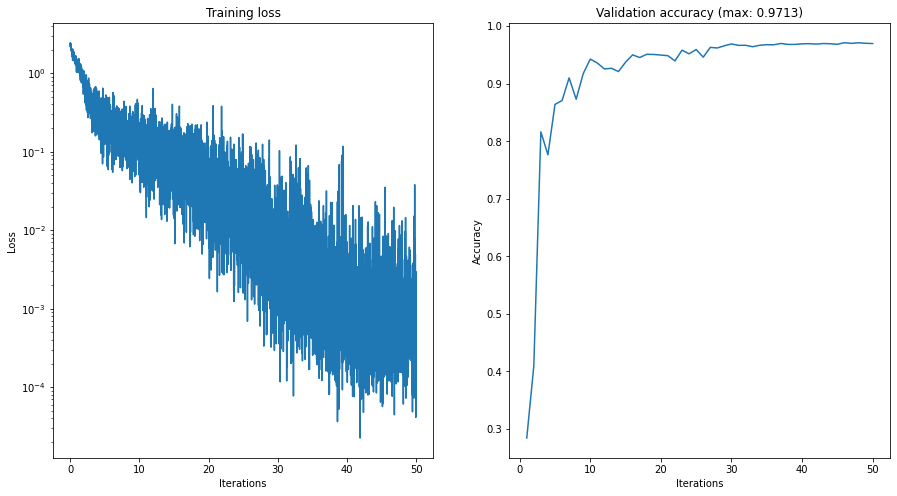

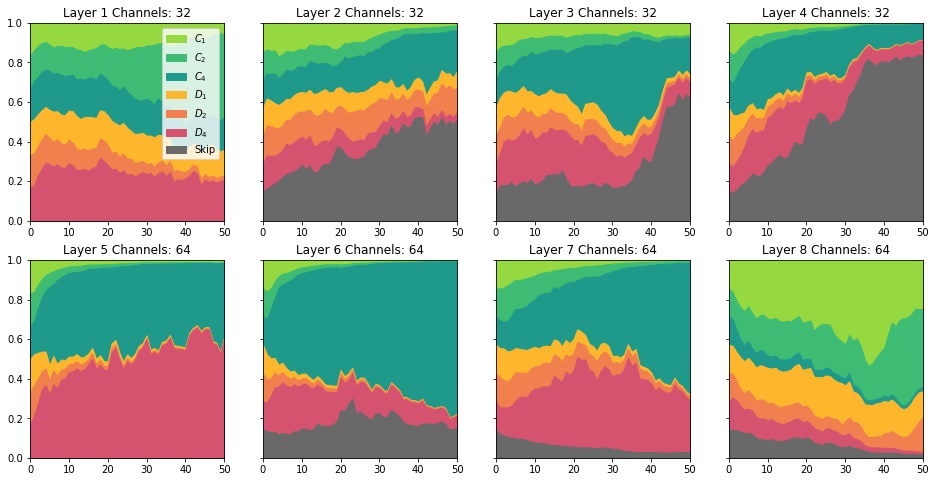

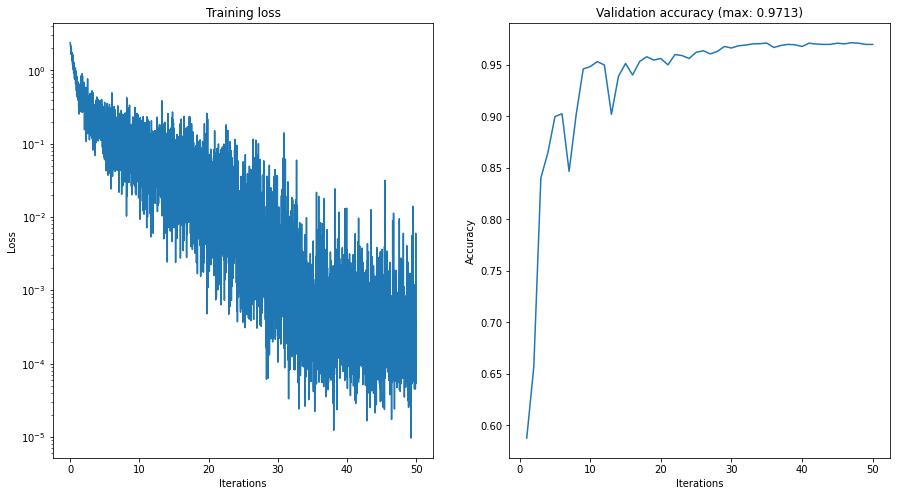

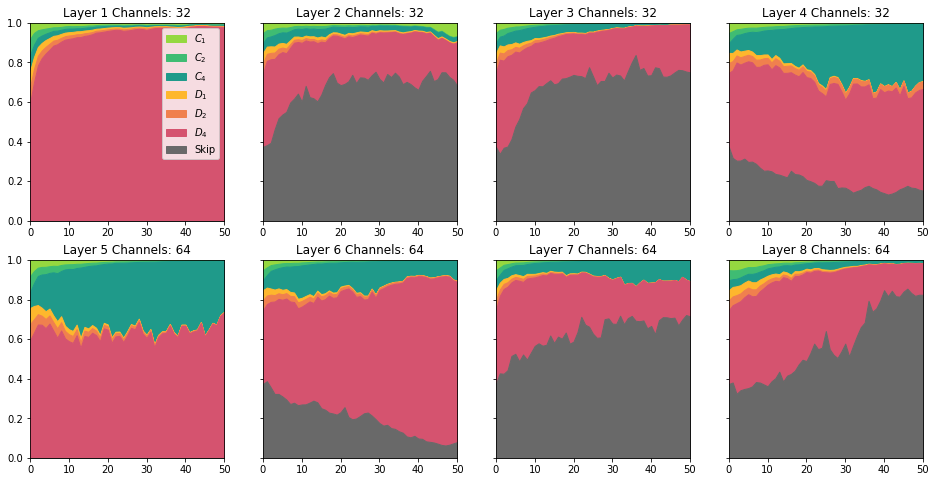

In [54]:
plotdea("out/olympe/logsdea_2022-08-11_14:41:53.pkl")
plotdea("out/olympe/logsdea_2022-08-11_14:42:15.pkl")


Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True, task='mnist')
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='mnist')


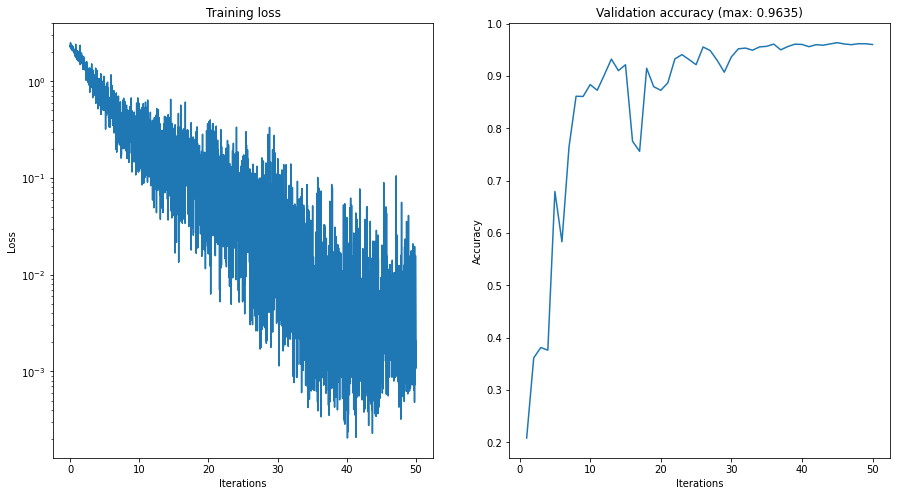

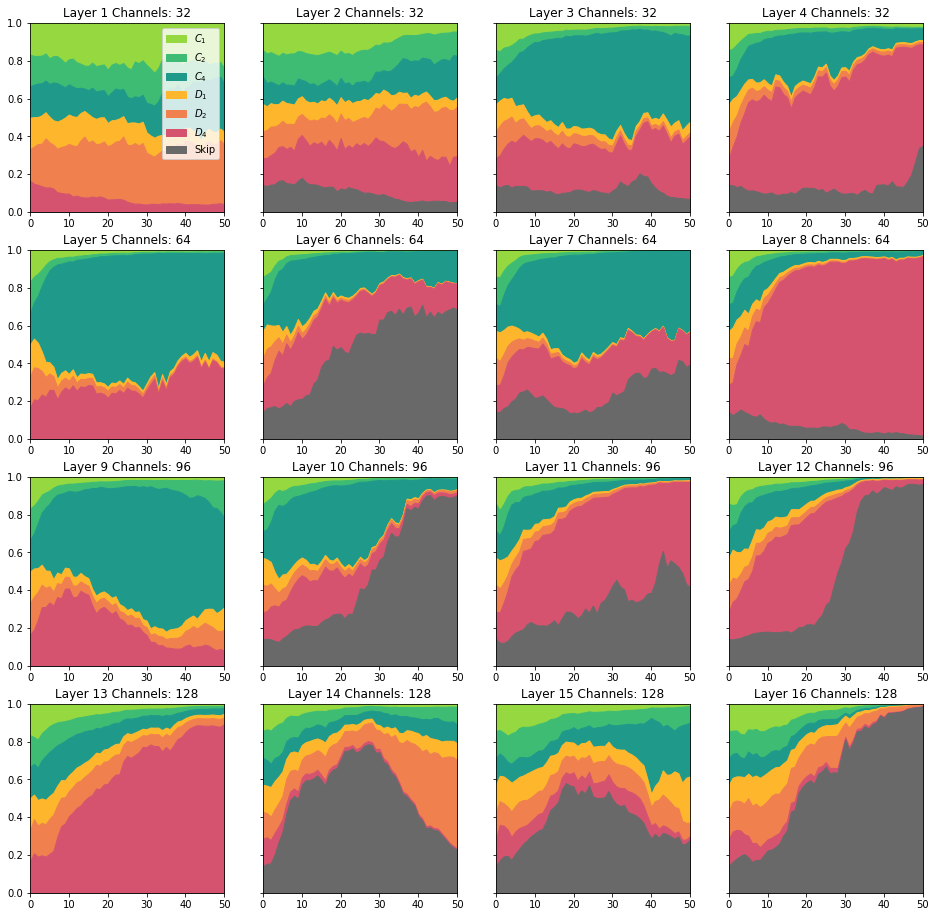

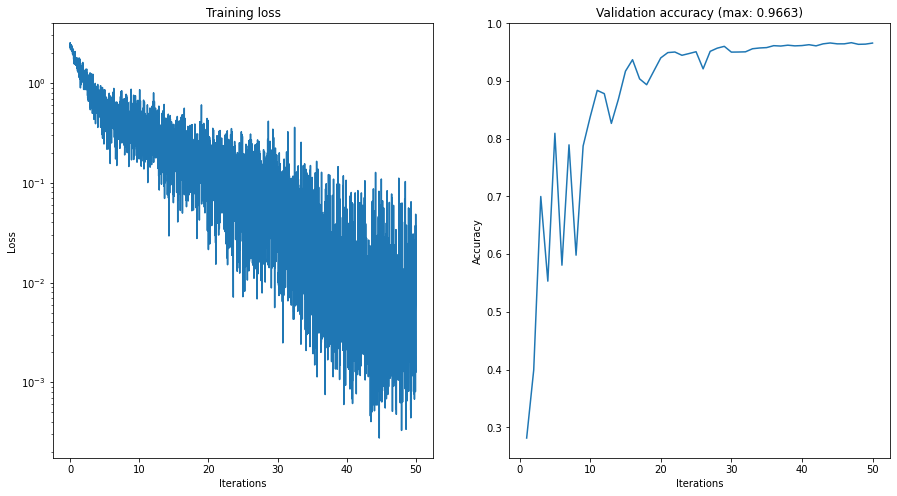

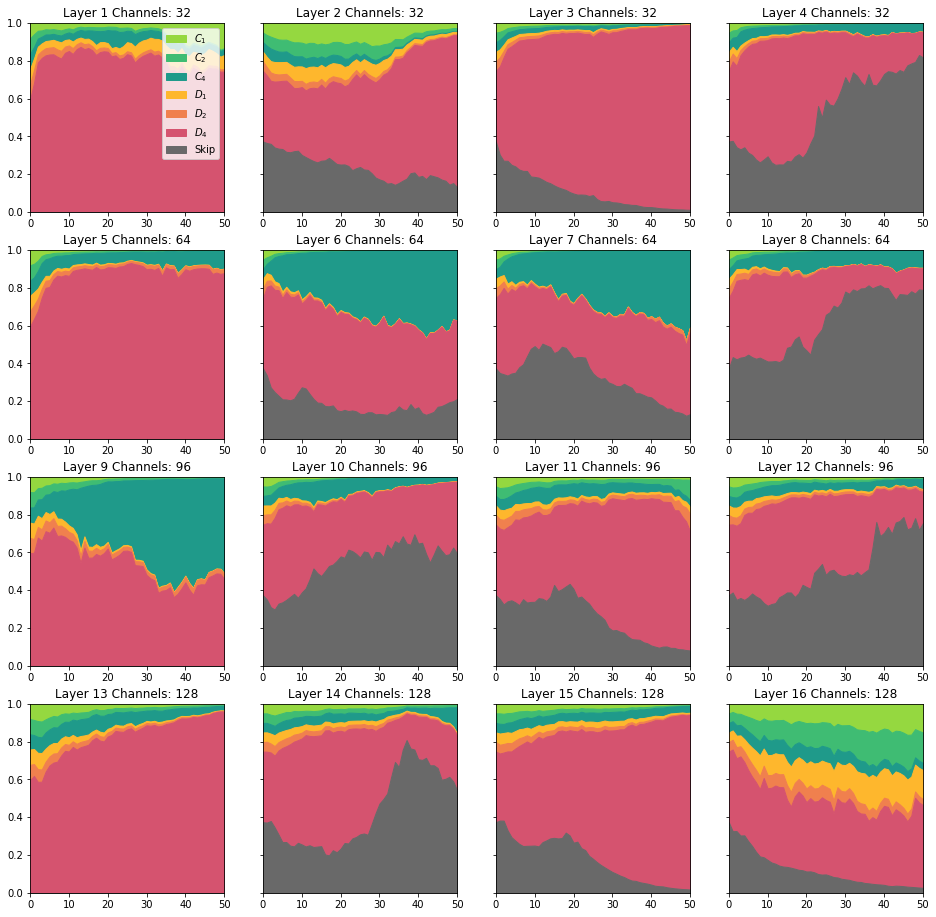

In [55]:
plotdea("out/olympe/logsdea_2022-08-11_17:21:27.pkl")
plotdea("out/olympe/logsdea_2022-08-11_17:21:31.pkl")

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='mnist', seed=-1)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True, task='mnist', seed=-1)


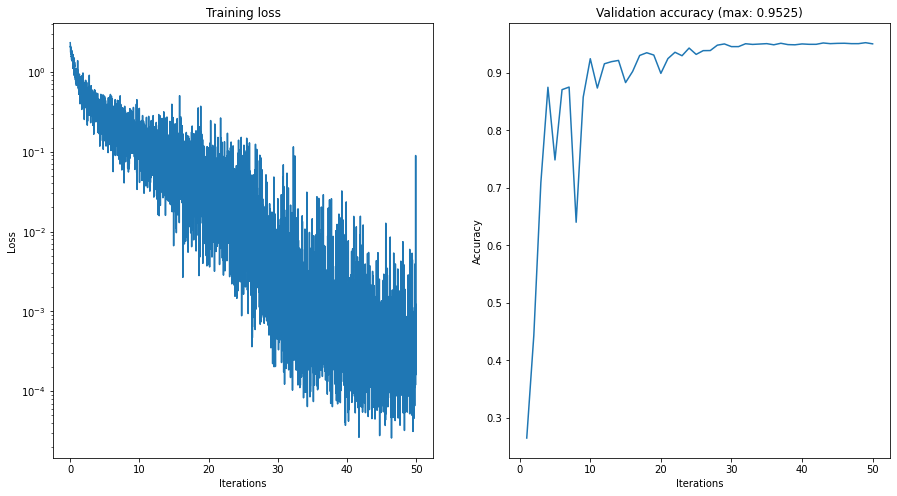

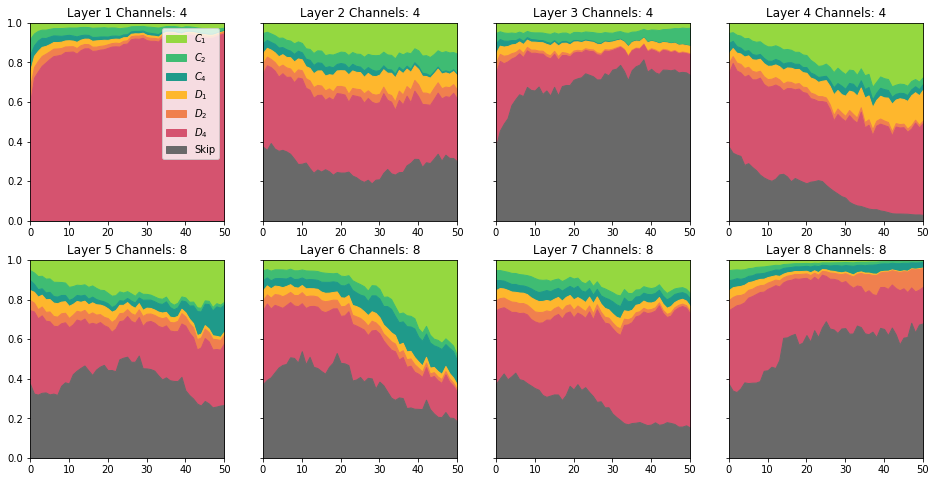

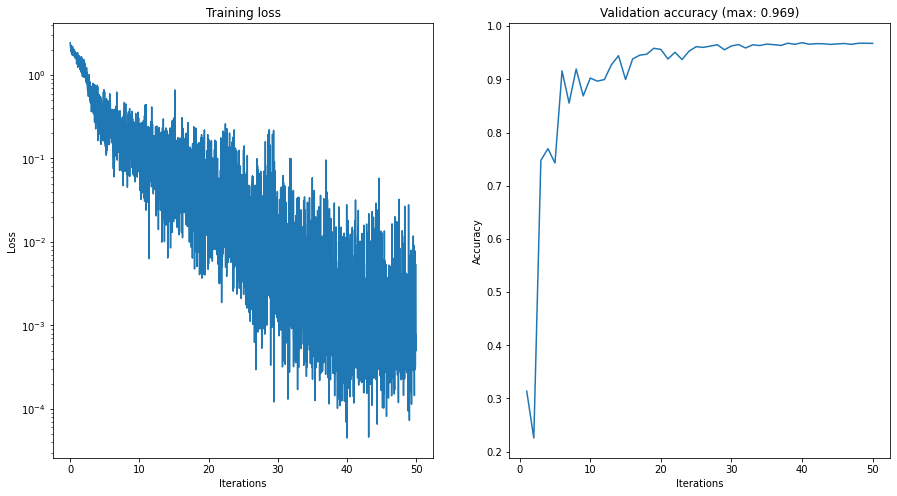

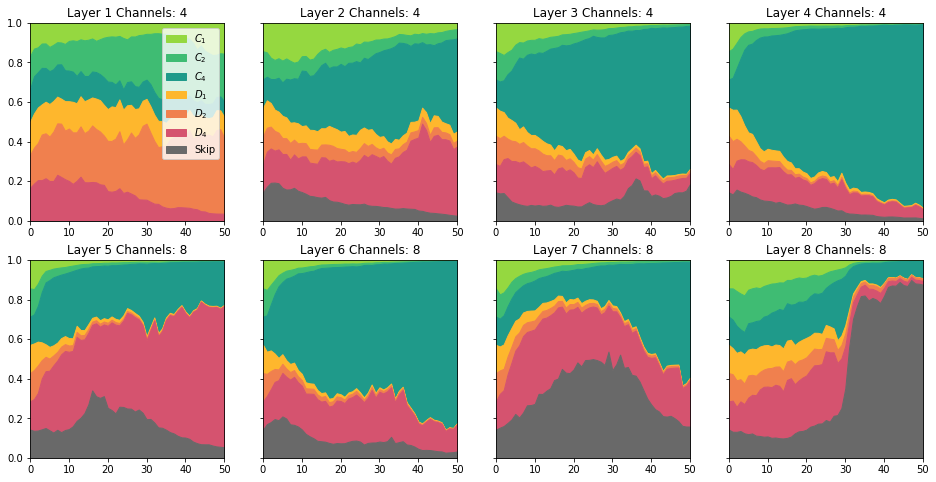

In [56]:
plotdea("out/olympe/logsdea_2022-08-12_13:58:46.pkl")
plotdea("out/olympe/logsdea_2022-08-12_13:59:00.pkl")

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=True, task='mnist', seed=-1, d16=True)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='mnist', seed=-1, d16=True)


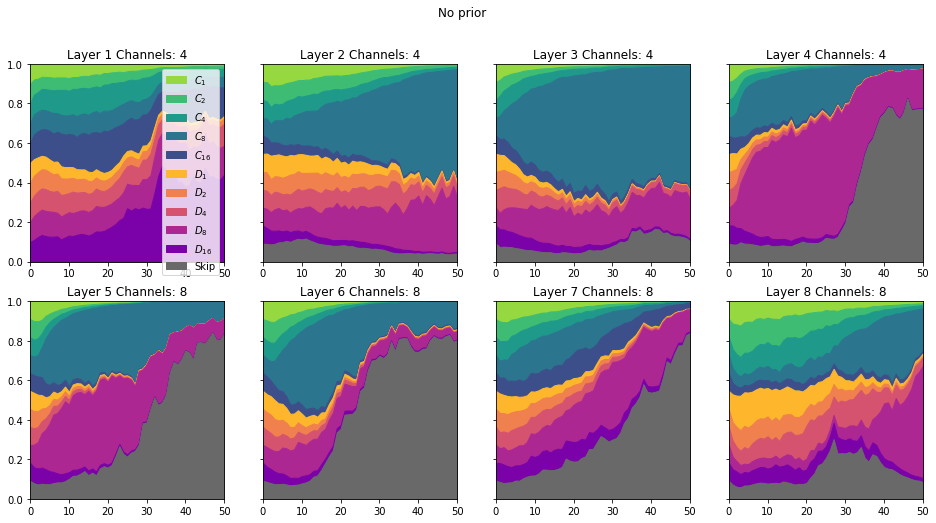

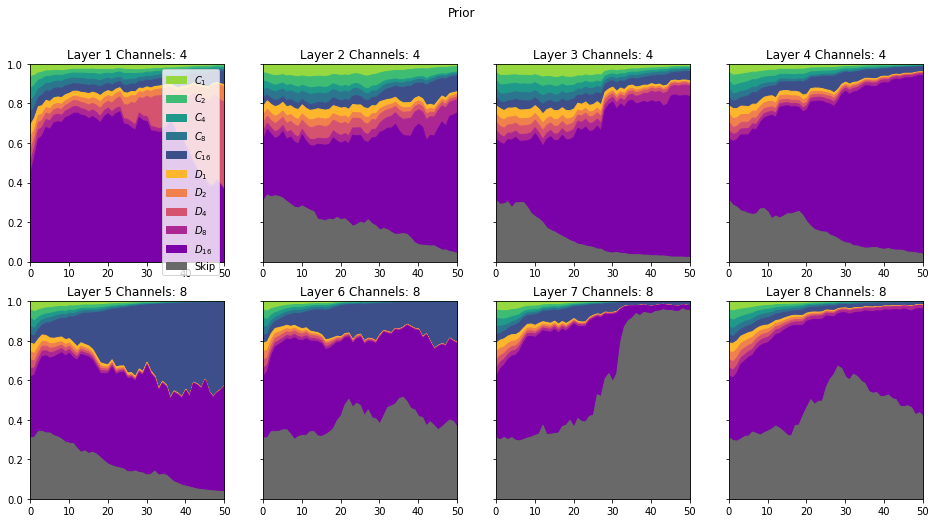

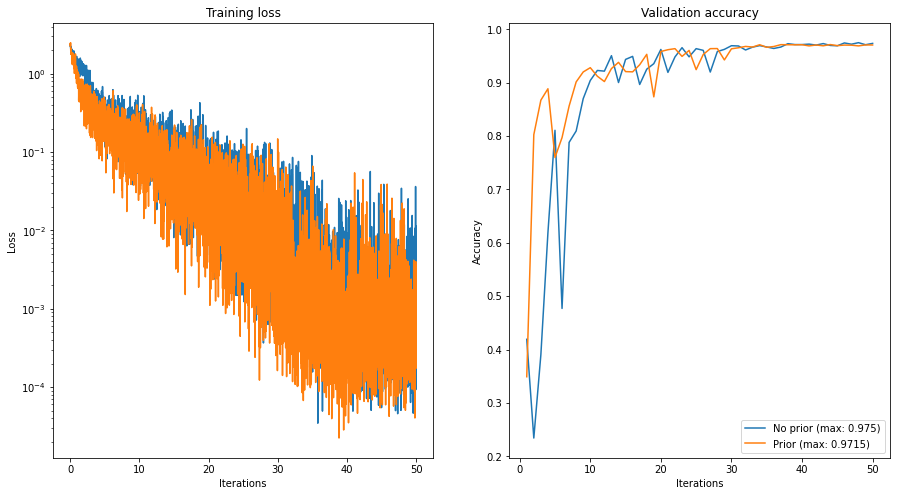

In [57]:
comparedea(["out/olympe/logsdea_2022-08-12_15:05:41.pkl", 
"out/olympe/logsdea_2022-08-12_15:15:13.pkl"], ["No prior", "Prior"])

Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='isic', seed=-1, d16=False)
Namespace(epochs=50, weightlr=0.01, alphalr=0.01, path=PosixPath('/tmpdir/maile'), equalize=False, task='galaxy10', seed=-1, d16=False)


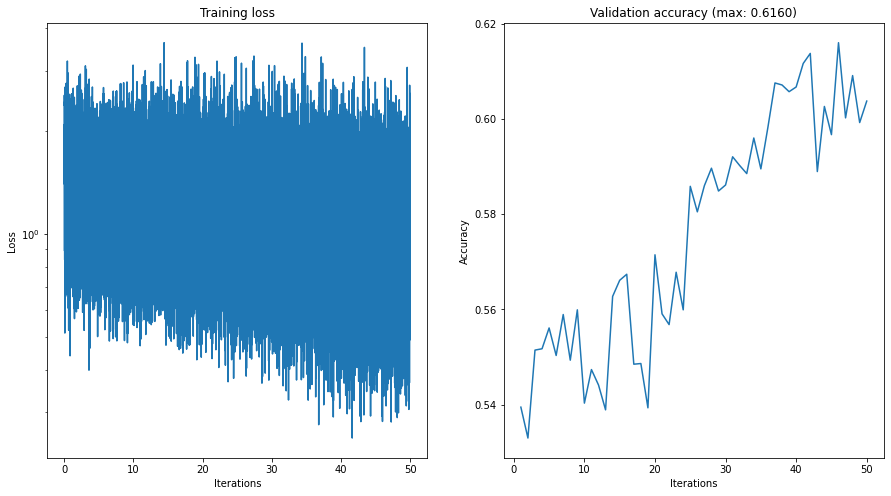

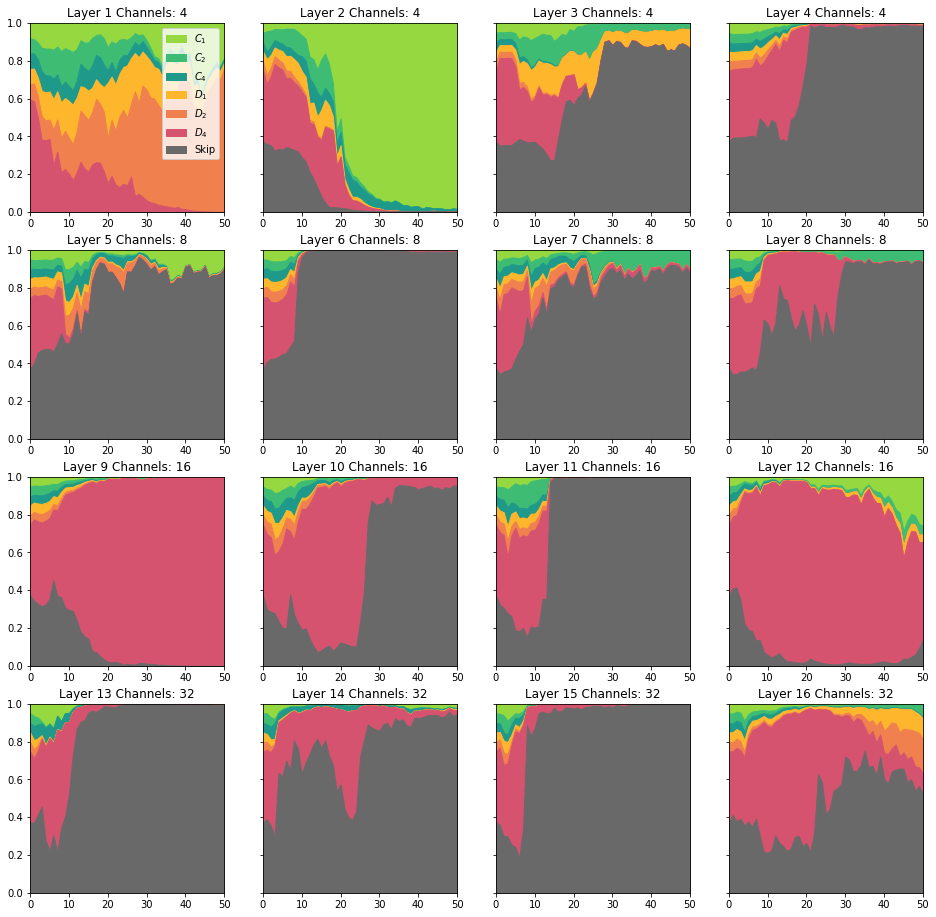

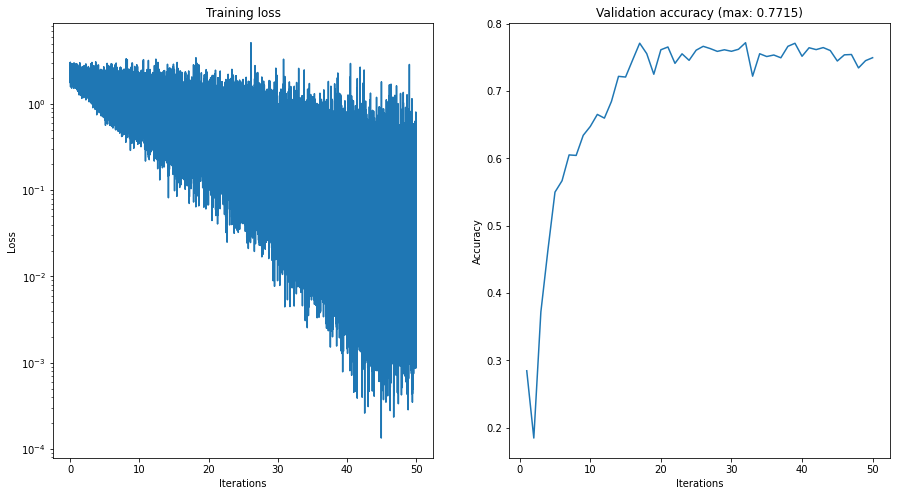

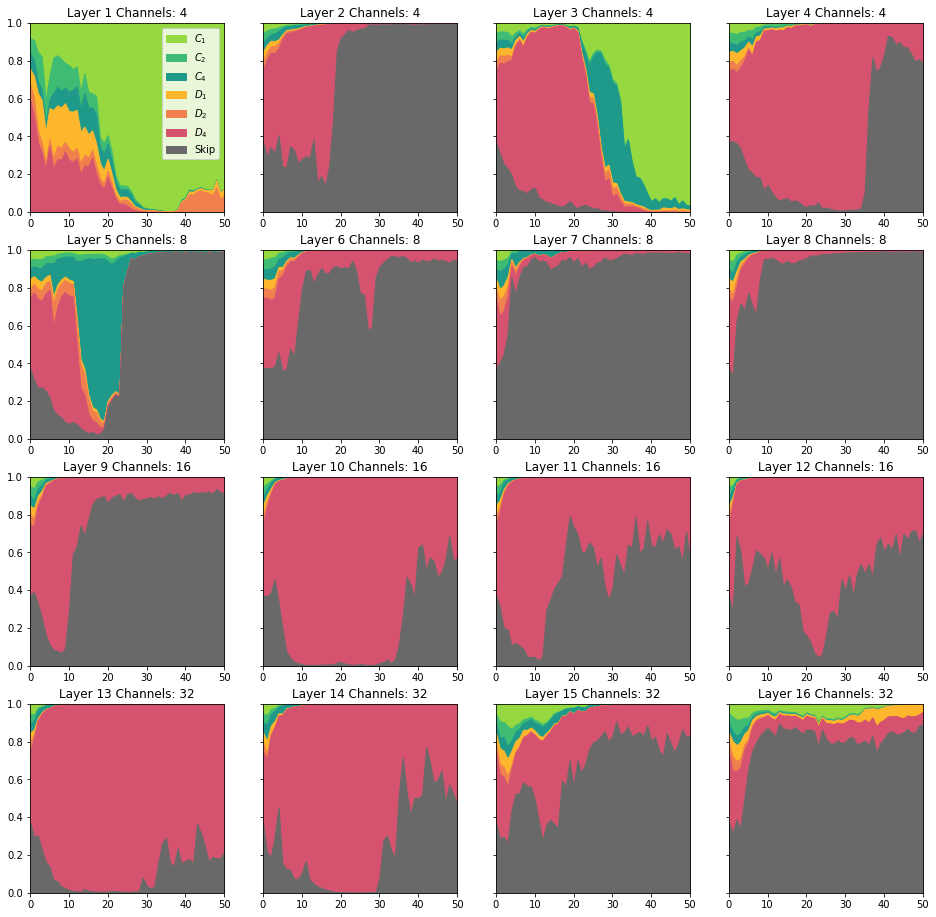

In [58]:
plotdea("out/olympe/logsdea_2022-08-17_11:43:54.pkl")
plotdea("out/olympe/logsdea_2022-08-17_16:08:18.pkl")